# Run torsion scans

In [1]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools import states
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol, AlchemicalState
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


logger = logging.getLogger()
logger.setLevel(logging.INFO)


DEBUG:matplotlib:$HOME=/home/zhangi
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.1
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
RDKit WARNING: [11:41:13] Enabling RDKit 2019.09.3 jupyter extensions


### Define helper function for alchemifying

In [46]:
def alchemify(htf, endstate):

    # Define simulation parameters
    temperature = 300 * unit.kelvin
    nsteps = 10000
    timestep = 2.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds

    system = htf.hybrid_system
    positions = htf.hybrid_positions

    # Alchemify the hybrid system
    atoms_to_alchemify = list(htf._atom_classes['unique_new_atoms']) + list(htf._atom_classes['unique_old_atoms'])

    alch_factory = AbsoluteAlchemicalFactory(consistent_exceptions=False)
    alchemical_region = AlchemicalRegion(alchemical_atoms=list(atoms_to_alchemify), alchemical_torsions=True) 
#                                          annihilate_sterics=True,
#                                          annihilate_electrostatics=True)
    reference_forces = {force.__class__.__name__: force for force in htf._topology_proposal.new_system.getForces()}
    print("torsion list: ", alch_factory._build_alchemical_torsion_list(atoms_to_alchemify, reference_forces, htf._topology_proposal.new_system))
    alchemical_system = alch_factory.create_alchemical_system(htf.hybrid_system, alchemical_region)

    # Initialize compound thermodynamic states at different temperatures and alchemical states.
    protocol = {'temperature': [300*unit.kelvin],
                'lambda_electrostatics': [0.0],
                'lambda_sterics': [0.0],
               'lambda_torsions': [0.0]}
    alchemical_state = AlchemicalState.from_system(alchemical_system)
    alchemical_state.set_alchemical_parameters(endstate)

    compound_state = states.create_thermodynamic_state_protocol(alchemical_system, 
                                                                 protocol=protocol, 
                                                                 composable_states=[alchemical_state])[0]
    compound_state.lambda_sterics = 0.0
    compound_state.lambda_electrostatics = 0.0
    compound_state.lambda_torsions = 0.0
    
    print("sterics ", compound_state.lambda_sterics)
    print("elec ", compound_state.lambda_electrostatics)
    print("torsions ", compound_state.lambda_torsions)
    
    
#     thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(alchemical_system, temperature=temperature), composable_states=[alchemical_state])

    
    
    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = compound_state.create_context(integrator, platform=platform)    

    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(compound_state.reduced_potential(context))
    
#     md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")


#     # Minimize
#     openmm.LocalEnergyMinimizer.minimize(context)

#     # Run equilibration
#     for step in tqdm(range(nsteps)):
#         integrator.step(1)
    
    return context, compound_state

### Sub-class MCDihedralRotationMove

In [3]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [4]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
    d_masses = {}
    # Set particle masses to 0
    for index in hybrid_indices:
        d_masses[index] = htf.hybrid_system.getParticleMass(index)
        htf.hybrid_system.setParticleMass(index, 0.0)
    
    # Turn off constraints involving massless particles
    for i in reversed(range(htf.hybrid_system.getNumConstraints())):
        p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
        if p1 in hybrid_indices or p2 in hybrid_indices:
            if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
                htf.hybrid_system.removeConstraint(i)
    
    # Create context, compound state
    context, compound_state = alchemify(htf, endstate)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(compound_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(compound_state, sampler_state)
        
        sampler_state.apply_to_context(context)
        energy = compound_state.reduced_potential(context)
        energies = [energy]
    
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
    # Set masses back to normal
    for index in hybrid_indices:
        compound_state.system.setParticleMass(index, d_masses[index])
    compound_state.apply_to_context(context)
    
    return d_corrected
    
    

In [130]:
torsion_scans = []

###  Generate torsion scans for r-htf with 4 flattened exceptions and all torsions and softened torsions, electrostatics, sterics (sidechains not mapped): ALA->THR lambda = 1

In [6]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res='THR', 
                                         system=atp.system, 
                                         positions=atp.positions,
                                         system_generator=sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True,
                                         endstate=1,
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR


INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 121 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (14, 10, 8, 18, [1, Quantity(value=1.0655064807976995, unit=radian), Quantity(value=120.0, unit=kilocalorie/mole), 3])}
INFO:geometry:neglected angle terms include []
INFO:geometry:log probability choice of torsions and atom order: -13.553917196274867
INFO:geometry:c

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.5456169300542779.
INFO:geometry:	reduced angle potential = 1.8984292687198974.
INFO:geometry:	reduced angle potential = 0.14018493387289752.
INFO:geometry:	reduced angle potential = 0.740898179004869.
INFO:geometry:	reduced angle potential = 0.7532480136541813.
INFO:geometry:	reduced angle potential = 0.026210048080904488.
INFO:geometry:	reduced angle potential = 1.223984710996938.
INFO:geometry:	reduced angle potential = 0.38449108220230854.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle forc

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -45.185553028454905
INFO:geometry:final reduced energy -36.06908381512685
INFO:geometry:sum of energies: -36.069082690230346
INFO:geometry:magnitude of difference in the energies: 1.1248964995047572e-06
INFO:geometry:Final logp_proposal: 46.095064828935534


added energy components: [('CustomBondForce', 0.46435413250020935), ('CustomAngleForce', 11.155244930360222), ('CustomTorsionForce', 22.33136215188683), ('CustomBondForce', -79.1365142432022)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 12, 13, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517320112693091.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 24.08494743003856


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [7]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [8]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [9]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

sterics  0.0
elec  0.0
torsions  0.0
-24.914391103963382
-1.3185705
-24.914391103963382


INFO:root:Rotating by 0.26199997660982444 radians
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999973 radians
INFO:root:Rotating by 0.26200000000000145 radians
INFO:root:Rotating by 0.261999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians

-25.367229271171098
-25.228290336259295
-24.631713153843833
-23.983881439177146
-23.721057684227844
-24.04967000438684
-24.821667966730054
-25.618272285522227
-25.993350063454702
-25.733680969646606
-24.983589815698473
-24.160788392473737
-23.712882649594548
-23.857186405712845
-24.456323553452798
-25.10243457120473
-25.360268951169093
-25.026363469718923
-24.251976058263796
-23.457416025334165
-23.087708975349802
-23.35305374841234
-24.106033765265533
-24.927220985519778
raw d: {-1.0565704946517944: (-25.367229271171098, nan), -0.7945704946517944: (-25.228290336259295, nan), -0.5325704946517944: (-24.631713153843833, nan), -0.2705704946517944: (-23.983881439177146, nan), -0.00857049465179438: (-23.721057684227844, nan), 0.25342950534820563: (-24.04967000438684, nan), 0.5154295053482056: (-24.821667966730054, nan), 0.7774295053482057: (-25.618272285522227, nan), 1.0394295053482057: (-25.993350063454702, nan), 1.3014295053482057: (-25.733680969646606, nan), 1.5634295053482057: (-24.9835

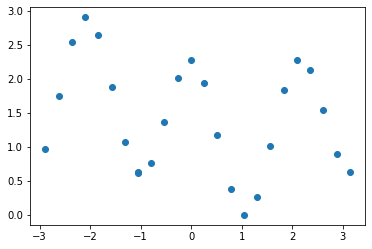

{-1.0565704946517944: (0.6261207922836043, nan),
 -0.7945704946517944: (0.7650597271954069, nan),
 -0.5325704946517944: (1.3616369096108691, nan),
 -0.2705704946517944: (2.009468624277556, nan),
 -0.00857049465179438: (2.272292379226858, nan),
 0.25342950534820563: (1.9436800590678622, nan),
 0.5154295053482056: (1.1716820967246484, nan),
 0.7774295053482057: (0.375077777932475, nan),
 1.0394295053482057: (0.0, nan),
 1.3014295053482057: (0.2596690938080961, nan),
 1.5634295053482057: (1.0097602477562297, nan),
 1.8254295053482057: (1.8325616709809651, nan),
 2.0874295053482057: (2.280467413860155, nan),
 2.3494295053482057: (2.1361636577418572, nan),
 2.6114295053482057: (1.5370265100019047, nan),
 2.8734295053482057: (0.8909154922499738, nan),
 3.1354295053482057: (0.633081112285609, nan),
 -2.8857558018313805: (0.9669865937357791, nan),
 -2.6237558018313805: (1.741374005190906, nan),
 -2.3617558018313805: (2.535934038120537, nan),
 -2.0997558018313804: (2.9056410881049004, nan),
 -1

In [10]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29]) 

###  Generate torsion scans for r-htf with 4 flattened exceptions and all torsions and softened torsions, electrostatics, sterics AND annihilate sterics and electrostatics (sidechains not mapped): ALA->THR lambda = 1

In [16]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res='THR', 
                                         system=atp.system, 
                                         positions=atp.positions,
                                         system_generator=sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True,
                                         endstate=1,
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR


INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 121 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (18, 10, 8, 14, [1, Quantity(value=-1.0655064807976995, unit=radian), Quantity(value=120.0, unit=kilocalorie/mole), 3])}
INFO:geometry:neglected angle terms include []
INFO:geometry:log probability choice of torsions and atom order: -13.659277711932692
INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.011911234796091677.
INFO:geometry:	reduced angle potential = 0.4351933921520479.
INFO:geometry:	reduced angle potential = 1.296674894916039.
INFO:geometry:	reduced angle potential = 0.0699347421667924.
INFO:geometry:	reduced angle potential = 0.08708370447614831.
INFO:geometry:	reduced angle potential = 0.07628373586958204.
INFO:geometry:	reduced angle potential = 0.4857526840151744.
INFO:geometry:	reduced angle potential = 0.05528763344039972.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -61.69559811448555
INFO:geometry:final reduced energy -52.57912880747584
INFO:geometry:sum of energies: -52.57912777626099
INFO:geometry:magnitude of difference in the energies: 1.0312148503999197e-06
INFO:geometry:Final logp_proposal: 47.60944395430903


added energy components: [('CustomBondForce', 0.6005430700011501), ('CustomAngleForce', 8.15924139321325), ('CustomTorsionForce', 14.240905841706963), ('CustomBondForce', -84.69628841940693)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 13, 12, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517320112693091.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 25.370167324821


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [17]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [18]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [19]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

sterics  0.0
elec  0.0
torsions  0.0
-33.25614143752553
2.847447
-33.25614143752553


INFO:root:Rotating by 0.26199987357691334 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.2620000000000027 radians
INFO:root:Rotating by 0.261999999999997 radians
INFO:root:Rotating by 0.26200000000000007 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 r

-33.25461995729613
-32.68482272994053
-31.8378223435889
-31.17835906126023
-31.074346136284998
-31.582399702796163
-32.414851721797994
-33.10784857485921
-33.29182861684032
-32.905666389423025
-32.2294814289584
-31.716579792006286
-31.723657743794977
-32.29777849827536
-33.14522816809488
-33.800907123601434
-33.898976324707135
-33.38619827378498
-32.55284167129732
-31.86317883985215
-31.684750255156327
-32.075278954112655
-32.75209261866968
-33.26148118199479
raw d: {3.109446918487549: (-33.25461995729613, nan), -2.9117383886920374: (-32.68482272994053, nan), -2.6497383886920374: (-31.8378223435889, nan), -2.3877383886920374: (-31.17835906126023, nan), -2.1257383886920374: (-31.074346136284998, nan), -1.8637383886920373: (-31.582399702796163, nan), -1.6017383886920373: (-32.414851721797994, nan), -1.3397383886920373: (-33.10784857485921, nan), -1.0777383886920373: (-33.29182861684032, nan), -0.8157383886920373: (-32.905666389423025, nan), -0.5537383886920373: (-32.2294814289584, nan), 

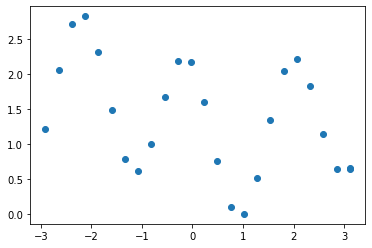

{3.109446918487549: (0.6443563674110067, nan),
 -2.9117383886920374: (1.2141535947666071, nan),
 -2.6497383886920374: (2.0611539811182347, nan),
 -2.3877383886920374: (2.720617263446904, nan),
 -2.1257383886920374: (2.8246301884221374, nan),
 -1.8637383886920373: (2.316576621910972, nan),
 -1.6017383886920373: (1.4841246029091408, nan),
 -1.3397383886920373: (0.7911277498479237, nan),
 -1.0777383886920373: (0.6071477078668153, nan),
 -0.8157383886920373: (0.9933099352841097, nan),
 -0.5537383886920373: (1.669494895748734, nan),
 -0.2917383886920373: (2.1823965327008494, nan),
 -0.029738388692037265: (2.1753185809121582, nan),
 0.23226161130796275: (1.6011978264317719, nan),
 0.49426161130796276: (0.7537481566122537, nan),
 0.7562616113079628: (0.09806920110570161, nan),
 1.0182616113079628: (0.0, nan),
 1.2802616113079628: (0.512778050922158, nan),
 1.5422616113079628: (1.3461346534098126, nan),
 1.8042616113079628: (2.035797484854985, nan),
 2.066261611307963: (2.214226069550808, nan)

In [22]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29]) 

###  Generate torsion scans for r-htf with 4 flattened exceptions and all torsions and softened torsions, electrostatics, sterics AND new system exceptions flattened (sidechains not mapped): ALA->THR lambda = 1

In [47]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res='THR', 
                                         system=atp.system, 
                                         positions=atp.positions,
                                         system_generator=sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True,
                                         endstate=1,
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR


INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 121 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (14, 10, 8, 18, [1, Quantity(value=1.0655064807976995, unit=radian), Quantity(value=120.0, unit=kilocalorie/mole), 3])}
INFO:geometry:neglected angle terms include []
INFO:geometry:log probability choice of torsions and atom order: -13.371595639480912
INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 2.7089299395213144.
INFO:geometry:	reduced angle potential = 0.321967074445487.
INFO:geometry:	reduced angle potential = 0.4326428243715022.
INFO:geometry:	reduced angle potential = 0.04227343652487156.
INFO:geometry:	reduced angle potential = 0.24780578454309793.
INFO:geometry:	reduced angle potential = 0.42046591830006785.
INFO:geometry:	reduced angle potential = 0.2166806090052044.
INFO:geometry:	reduced angle potential = 0.013180996084875165.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -41.39090989567055
INFO:geometry:final reduced energy -32.27443937797213
INFO:geometry:sum of energies: -32.274439557446
INFO:geometry:magnitude of difference in the energies: 1.7947386510286378e-07
INFO:geometry:Final logp_proposal: 42.771906546875435


added energy components: [('CustomBondForce', 1.3258877799928566), ('CustomAngleForce', 11.61678106847151), ('CustomTorsionForce', 21.770511729142584), ('CustomBondForce', -76.10409047327751)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 13, 12, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517320112693091.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 25.335788326841836


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [6]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [7]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [8]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [9]:
for i in range(htf._topology_proposal.new_system.getNumForces()):
    print(i, htf._topology_proposal.new_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2ba006ef5de0> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2ba006ef5de0> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2ba006ef5de0> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ba006ef5de0> >


In [48]:
unique_new = htf._topology_proposal.unique_new_atoms

In [11]:
unique_new

[10, 13, 14, 15, 16, 17, 18, 19]

In [49]:
# # Flatten all exceptions in new system
new_system = htf._topology_proposal.new_system
# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)

bonds = AbsoluteAlchemicalFactory._tabulate_bonds(new_system)

def is_bonded(i, j):
    if j in bonds[i]:
        return True
    return False

def is_proper_torsion(i, j, k, l):
    if is_bonded(i, j) and is_bonded(j, k) and is_bonded(k, l):
        return True
    return False

# # Flatten more torsions (for all atoms)
periodic_torsion = new_system.getForce(2)
for i in range(periodic_torsion.getNumTorsions()):
    p1, p2, p3, p4, periodicity, phase, k = periodic_torsion.getTorsionParameters(i)
    if p1 in unique_new or p2 in unique_new or p3 in unique_new or p4 in unique_new:
#     if p1 in unique_new and p2 in unique_new and p3 and unique_new and p4 in unique_new:
        
#             if p4 != 17 and p4 != 15 and:
        if not (p1 in unique_new and p2 in unique_new and p3 in unique_new and p4 in unique_new):
            if is_proper_torsion(p1, p2, p3, p4):
                print(p1, p2, p3, p4)
                periodic_torsion.setTorsionParameters(i, p1, p2, p3, p4, periodicity, phase, 0.*k)

# # Flatten sterics, electrostatics
# nb_force = new_system.getForce(3)
# for i in range(nb_force.getNumParticles()):
#     chargeProd, sigma, epsilon = nb_force.getParticleParameters(i)
#     nb_force.setParticleParameters(i, 0, sigma, 0)


4 6 8 10
4 6 8 10
4 6 8 10
6 8 10 13
6 8 10 14
6 8 10 14
6 8 10 14
6 8 10 14
6 8 10 18
6 8 10 18
6 8 10 18
6 8 10 18
8 10 14 15
8 10 14 16
8 10 14 17
8 10 18 19
8 10 18 19
8 10 18 19
8 10 18 19
9 8 10 13
9 8 10 14
9 8 10 18
10 8 11 20
10 8 11 20
10 8 11 20
11 8 10 13
11 8 10 14
11 8 10 14
11 8 10 14
11 8 10 14
11 8 10 18
11 8 10 18
11 8 10 18
11 8 10 18


In [50]:
# Build new r-htf
htf._topology_proposal._new_system = new_system

from perses.annihilation.relative import RepartitionedHybridTopologyFactory
htf = RepartitionedHybridTopologyFactory(topology_proposal=htf._topology_proposal,
                     current_positions=htf.old_positions(htf.hybrid_positions),
                     new_positions=htf.new_positions(htf.hybrid_positions),
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=True, ## NOTE: when this is True, don't need to modify old and new systems
                     omitted_terms=None,
                     flatten_torsions=True,
                     endstate=1)

INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

torsion list:  [8, 9, 10, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
sterics  0.0
elec  0.0
torsions  0.0


INFO:root:Rotating by 0.26199989048744843 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2620000000000006 radians
INFO:root:Rotating by 0.26200000000000184 radians
INFO:root:Rotating by 0.26199999999999724 radians
INFO:root:Rotating by 0.26199999999999996 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2619999999999978 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians


-26.85454805407864
-0.84139407
-26.85454805407864
-26.85452377477512
-26.854527943123447
-26.854533010556576
-26.8545388187639
-26.854516258007962
-26.85451730046842
-26.854561438606286
-26.854541739109333
-26.85455562694525
-26.85455026940045
-26.854532758715752
-26.854541404192776
-26.854536545662445
-26.854537390514665
-26.85455141976602
-26.8545412691247
-26.85452159380372
-26.854536450638744
-26.854518038255616


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000034 radians


-26.854538770505297
-26.854556820902243
-26.854543056839834
-26.854527797787576
-26.854541310942597
raw d: {-0.5793940668106079: (-26.85452377477512, nan), -0.3173940668106079: (-26.854527943123447, nan), -0.05539406681060788: (-26.854533010556576, nan), 0.20660593318939213: (-26.8545388187639, nan), 0.46860593318939214: (-26.854516258007962, nan), 0.7306059331893922: (-26.85451730046842, nan), 0.9926059331893922: (-26.854561438606286, nan), 1.2546059331893922: (-26.854541739109333, nan), 1.5166059331893922: (-26.85455562694525, nan), 1.7786059331893922: (-26.85455026940045, nan), 2.040605933189392: (-26.854532758715752, nan), 2.302605933189392: (-26.854541404192776, nan), 2.5646059331893922: (-26.854536545662445, nan), 2.8266059331893922: (-26.854537390514665, nan), 3.0886059331893922: (-26.85455141976602, nan), -2.932579373990194: (-26.8545412691247, nan), -2.670579373990194: (-26.85452159380372, nan), -2.408579373990194: (-26.854536450638744, nan), -2.146579373990194: (-26.854518038

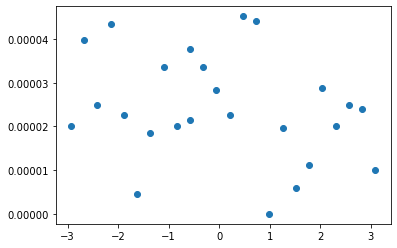

{-0.5793940668106079: (3.766383116499128e-05, nan),
 -0.3173940668106079: (3.349548283893e-05, nan),
 -0.05539406681060788: (2.8428049709816605e-05, nan),
 0.20660593318939213: (2.2619842386717437e-05, nan),
 0.46860593318939214: (4.518059832392396e-05, nan),
 0.7306059331893922: (4.413813786641185e-05, nan),
 0.9926059331893922: (0.0, nan),
 1.2546059331893922: (1.969949695279638e-05, nan),
 1.5166059331893922: (5.811661036858595e-06, nan),
 1.7786059331893922: (1.116920583754677e-05, nan),
 2.040605933189392: (2.867989053356723e-05, nan),
 2.302605933189392: (2.003441350950652e-05, nan),
 2.5646059331893922: (2.4892943841337e-05, nan),
 2.8266059331893922: (2.4048091621153844e-05, nan),
 3.0886059331893922: (1.0018840267633777e-05, nan),
 -2.932579373990194: (2.0169481587117843e-05, nan),
 -2.670579373990194: (3.9844802564914517e-05, nan),
 -2.408579373990194: (2.498796754224486e-05, nan),
 -2.146579373990194: (4.340035066974224e-05, nan),
 -1.884579373990194: (2.266810098916494e-05,

In [51]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29]) 

###  Generate torsion scans for r-htf with 4 flattened exceptions and all torsions and softened torsions, electrostatics, sterics AND new system exceptions flattened (sidechains not mapped): THR->ALA lambda = 0

In [5]:
from simtk.openmm import app, unit
from openmmforcefields.generators import SystemGenerator


In [6]:

# Get pdb and system geneator for capped THR->ALA in vacuum
pdb = app.PDBFile("../input/thr_vacuum.pdb")

forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
system_generator = SystemGenerator(forcefields=forcefield_files,
                               barostat=barostat,
                               forcefield_kwargs={'removeCMMotion': False,
                                                    'ewaldErrorTolerance': 1e-4,
                                                    'constraints' : app.HBonds,
                                                    'hydrogenMass' : 4 * unit.amus},
                                periodic_forcefield_kwargs=None,
                                small_molecule_forcefield='gaff-2.11',
                                nonperiodic_forcefield_kwargs = {'nonbondedMethod': app.NoCutoff}, 
                                   molecules=None, 
                                   cache=None)
system = system_generator.create_system(pdb.topology) 
positions = unit.quantity.Quantity(value = np.array([list(atom_pos) for atom_pos in pdb.positions.value_in_unit_system(unit.md_unit_system)]), unit = unit.nanometers)


In [7]:
rhtf = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, 
                                         endstate=0, 
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
INFO:proposal_generator:{7: 9}
INFO:proposal_generator:{8: 9}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{7: 10}
INFO:proposal_generator:{8: 10}
INFO:proposal_generator:{9: 10}
INFO:proposal_generator:{7: 11}
INFO:proposal_generator:{8: 11}
INFO:proposal_generator:{9: 11}
INFO:proposal_generator:{7: 12}
INFO:proposal_generator:{8: 12}
INFO:proposal_generator:{9: 12}
INFO:proposal_generator:{7: 13}
INFO:proposal_generator:{8: 13}
INFO:proposal_generator:{9: 13}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA


INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {}
INFO:geometry:neglected angle terms include []
INFO:geometry:log probability choice of torsions and atom order: -5.78074351579233
INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.9915047875152379.
INFO:geometry:	reduced angle potential = 0.21396765029844242.
INFO:geometry:	reduced angle potential = 0.0016376828499885898.
INFO:geometry:	reduced angle potential = 4.931645749027829.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 34.844304820385794
INFO:geometry:final reduced energy 43.96223397644937
INFO:geometry:sum of energies: 43.96223256650479
INFO:geometry:magnitude of difference in the energies: 1.409944580643696e-06
INFO:geometry:Final logp_proposal: 18.54166345166149


added energy components: [('CustomBondForce', 0.6663124446045402), ('CustomAngleForce', 9.365921180344877), ('CustomTorsionForce', 11.381435519335183), ('CustomBondForce', 13.430635676101199)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 13, 16, 17, 15, 19]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, swit

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions
INFO:geometry:There are 8 new atoms


conducting subsequent work with the following platform: CUDA


INFO:geometry:	reduced angle potential = 0.5305209475348288.
INFO:geometry:	reduced angle potential = 0.005165150791445113.
INFO:geometry:	reduced angle potential = 0.4788702500646966.
INFO:geometry:	reduced angle potential = 0.01392576095456174.
INFO:geometry:	reduced angle potential = 0.8672997245591195.
INFO:geometry:	reduced angle potential = 0.2596979326900967.
INFO:geometry:	reduced angle potential = 0.2124939602020238.
INFO:geometry:	reduced angle potential = 0.70608244841363.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle forces in the no-nonbonded final system
I

conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
added energy components: [('CustomBondForce', 1.1114824464808768), ('CustomAngleForce', 9.449446410979123), ('CustomTorsionForce', 18.656515884333214), ('CustomBondForce', -92.18526532593798)]


INFO:geometry:total reduced energy added from growth system: -62.96782058414476
INFO:geometry:final reduced energy -53.84989368793476
INFO:geometry:sum of energies: -53.84989283802577
INFO:geometry:magnitude of difference in the energies: 8.499089929614456e-07
INFO:geometry:Final logp_proposal: 39.379738578232455
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z

In [36]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
THR2-CB 26
THR2-HB1 27
THR2-HB2 28
THR2-HB3 29
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [37]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [38]:
for atom in rhtf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (C) of chain 0 residue 1 (ALA)> 11
<Atom 12 (O) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB1) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB3) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [39]:
for i in range(rhtf._topology_proposal.new_system.getNumForces()):
    print(i, rhtf._topology_proposal.new_system.getForce(i))

0 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b40067403f0> >
1 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b40064f8c90> >
2 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b40064f8c90> >
3 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b40064f8c90> >


In [40]:
# Flatten all exceptions in new system
new_system = rhtf._topology_proposal.new_system
nb_force = new_system.getForce(3)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    nb_force.setExceptionParameters(i, p1, p2, 0, sigma, 0)


In [31]:
# Build new htf
rhtf._topology_proposal._new_system = new_system

from perses.annihilation.relative import HybridTopologyFactory
htf = HybridTopologyFactory(topology_proposal=rhtf._topology_proposal,
                     current_positions=rhtf.old_positions(rhtf.hybrid_positions),
                     new_positions=rhtf.new_positions(rhtf.hybrid_positions),
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=True, ## NOTE: when this is True, don't need to modify old and new systems
                     omitted_terms=None,
                     flatten_torsions=True)

INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system except

sterics  0.0
elec  0.0
torsions  0.0
-10.050355769935354
-0.87087864
-10.050355769935354


INFO:root:Rotating by 0.2619999873535249 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.26199999999999907 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179584 radians
INFO:root:Rotating by 0.26199999999999823 radians


-10.050368398940533
-10.050362386124208
-10.05036637973346
-10.050354040466575
-10.050355949154918
-10.050358888355744
-10.050343821964518
-10.050356830317767
-10.050356916940556
-10.050353198134632
-10.050340449649745
-10.050354676696022
-10.050349407640883
-10.050368180890064
-10.050351674768349
-10.050362436903084
-10.050339831342257

INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999957 radians



-10.050356406164802
-10.05035175243016
-10.050344502998854
-10.050368903742298
-10.050364919094024
-10.050366275188715
-10.05034382495151
raw d: {-0.6088786368370056: (-10.050368398940533, nan), -0.3468786368370056: (-10.050362386124208, nan), -0.08487863683700558: (-10.05036637973346, nan), 0.17712136316299443: (-10.050354040466575, nan), 0.43912136316299444: (-10.050355949154918, nan), 0.7011213631629944: (-10.050358888355744, nan), 0.9631213631629945: (-10.050343821964518, nan), 1.2251213631629945: (-10.050356830317767, nan), 1.4871213631629945: (-10.050356916940556, nan), 1.7491213631629945: (-10.050353198134632, nan), 2.0111213631629945: (-10.050340449649745, nan), 2.2731213631629945: (-10.050354676696022, nan), 2.5351213631629945: (-10.050349407640883, nan), 2.7971213631629945: (-10.050368180890064, nan), 3.0591213631629945: (-10.050351674768349, nan), -2.9620639440165917: (-10.050362436903084, nan), -2.7000639440165917: (-10.050339831342257, nan), -2.4380639440165917: (-10.0503

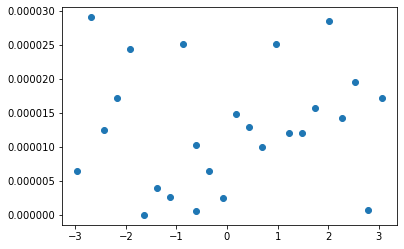

{-0.6088786368370056: (5.048017648334735e-07, nan),
 -0.3468786368370056: (6.517618089674215e-06, nan),
 -0.08487863683700558: (2.524008838378222e-06, nan),
 0.17712136316299443: (1.48632757230871e-05, nan),
 0.43912136316299444: (1.2954587379709892e-05, nan),
 0.7011213631629944: (1.001538655387435e-05, nan),
 0.9631213631629945: (2.5081777780044945e-05, nan),
 1.2251213631629945: (1.2073424530356647e-05, nan),
 1.4871213631629945: (1.1986801741414865e-05, nan),
 1.7491213631629945: (1.5705607665950083e-05, nan),
 2.0111213631629945: (2.845409255236575e-05, nan),
 2.2731213631629945: (1.4227046275294697e-05, nan),
 2.5351213631629945: (1.949610141416258e-05, nan),
 2.7971213631629945: (7.228522331814702e-07, nan),
 3.0591213631629945: (1.722897394884626e-05, nan),
 -2.9620639440165917: (6.466839213459252e-06, nan),
 -2.7000639440165917: (2.907240004113021e-05, nan),
 -2.4380639440165917: (1.2497577495551582e-05, nan),
 -2.1760639440165916: (1.7151312137642094e-05, nan),
 -1.9140639440

In [32]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29]) 

-22.10941842751517


100%|██████████| 10000/10000 [00:01<00:00, 5847.48it/s]
INFO:root:Rotating by 0.2620001133349332 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000003 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000084 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 

-1.4848638
-0.03522379469260741
-0.035219317190535594
-0.035228956216009744
-0.03522604091112509
-0.03522549429145923
-0.03522567649801451
-0.03523016893504988
-0.035229873222771615
-0.035236853824734155
-0.03523284826751046
-0.03523714953701241
-0.035236853824734155
-0.03523729589965518
-0.03523747810621048
-0.03523766031276577
-0.03523288709841569
-0.03523111879873155
-0.035235420068233506
-0.035230381011532266
-0.03523067672381053
-0.035229941923603944
-0.03522441598709102
-0.03522427261144096
-0.03522332274775928
-0.03522846933619807
raw d: {-1.2228637580871582: (-0.035219317190535594, nan), -0.9608637580871582: (-0.035228956216009744, nan), -0.6988637580871582: (-0.03522604091112509, nan), -0.43686375808715816: (-0.03522549429145923, nan), -0.17486375808715815: (-0.03522567649801451, nan), 0.08713624191284186: (-0.03523016893504988, nan), 0.34913624191284187: (-0.035229873222771615, nan), 0.6111362419128419: (-0.035236853824734155, nan), 0.8731362419128419: (-0.03523284826751046, 

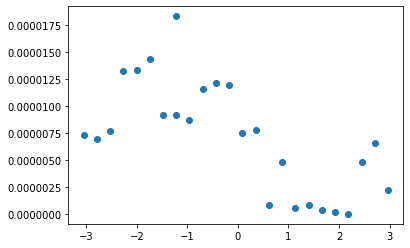

{-1.2228637580871582: (1.8343122230174425e-05, nan),
 -0.9608637580871582: (8.70409675602507e-06, nan),
 -0.6988637580871582: (1.1619401640676486e-05, nan),
 -0.43686375808715816: (1.216602130654082e-05, nan),
 -0.17486375808715815: (1.1983814751259647e-05, nan),
 0.08713624191284186: (7.491377715891645e-06, nan),
 0.34913624191284187: (7.787089994153173e-06, nan),
 0.6111362419128419: (8.064880316141498e-07, nan),
 0.8731362419128419: (4.812045255306319e-06, nan),
 1.135136241912842: (5.107757533595603e-07, nan),
 1.397136241912842: (8.064880316141498e-07, nan),
 1.659136241912842: (3.644131105901005e-07, nan),
 1.921136241912842: (1.8220655528811136e-07, nan),
 2.183136241912842: (0.0, nan),
 2.445136241912842: (4.773214350078936e-06, nan),
 2.707136241912842: (6.541514034216767e-06, nan),
 2.969136241912842: (2.2402445322630693e-06, nan),
 -3.0520490652667442: (7.279301233502344e-06, nan),
 -2.7900490652667442: (6.983588955240816e-06, nan),
 -2.528049065266744: (7.718389161824601e-0

In [119]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(rhtf, 0, False, [6, 8, 26, 27], [6, 8, 10, 13], [28, 29], repartitioned=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

-17.686529117180065


100%|██████████| 10000/10000 [00:01<00:00, 5799.25it/s]
INFO:root:Rotating by -0.706255991811203 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000142 radians
INFO:root:Rotating by 0.2619999999999858 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.261999999999995 radians
INFO:root:Rotating by 0.26200000000000595 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2

2.1061172
11.822919755090672
13.072634773815341
12.392222669853272
11.880004591761201
11.891937355259998
12.471425529210494
13.320472208357064
13.971549494185043
14.059868378995398
13.536148097328654
12.695339880392105
12.00453792193969
11.830604911648352
12.227698873564519
12.908696551264462
13.417360492642324
13.399844559049988
12.816078474487268
11.966678975227207
11.319466483424678
11.237124968051406
11.76556370727629
12.607156037743847
13.294533665889311
13.462882831971857
raw d: {2.3681172485351563: (13.072634773815341, nan), 2.6301172485351563: (12.392222669853272, nan), 2.8921172485351563: (11.880004591761201, nan), -3.12906805864443: (11.891937355259998, nan), -2.86706805864443: (12.471425529210494, nan), -2.60506805864443: (13.320472208357064, nan), -2.34306805864443: (13.971549494185043, nan), -2.08106805864443: (14.059868378995398, nan), -1.8190680586444299: (13.536148097328654, nan), -1.5570680586444299: (12.695339880392105, nan), -1.2950680586444299: (12.00453792193969, n

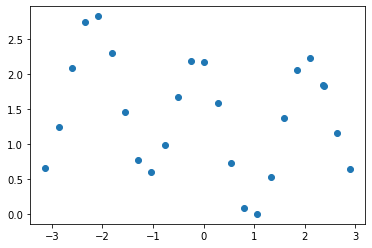

{2.3681172485351563: (1.8355098057639356, nan),
 2.6301172485351563: (1.155097701801866, nan),
 2.8921172485351563: (0.6428796237097956, nan),
 -3.12906805864443: (0.654812387208592, nan),
 -2.86706805864443: (1.2343005611590883, nan),
 -2.60506805864443: (2.083347240305658, nan),
 -2.34306805864443: (2.734424526133637, nan),
 -2.08106805864443: (2.8227434109439926, nan),
 -1.8190680586444299: (2.2990231292772485, nan),
 -1.5570680586444299: (1.4582149123406989, nan),
 -1.2950680586444299: (0.7674129538882841, nan),
 -1.0330680586444299: (0.5934799435969467, nan),
 -0.7710680586444298: (0.9905739055131129, nan),
 -0.5090680586444298: (1.6715715832130567, nan),
 -0.24706805864442982: (2.180235524590918, nan),
 0.014931941355570189: (2.1627195909985826, nan),
 0.2769319413555702: (1.5789535064358624, nan),
 0.5389319413555702: (0.7295540071758015, nan),
 0.8009319413555702: (0.0823415153732725, nan),
 1.0629319413555702: (0.0, nan),
 1.3249319413555702: (0.5284387392248835, nan),
 1.5869

In [120]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(rhtf, 0, True, [6, 8, 10, 18], [6, 8, 10, 11], [13, 14, 15, 16, 17, 19], repartitioned=True)

# Plot diff torsion scans all on one plot

In [135]:
import collections

In [136]:
len(torsion_scans)

2

In [129]:
torsion_scans

[{-3.085164217625753: (2.09873575283126e-05, nan),
  -2.823164217625753: (1.531057788284329e-05, nan),
  -2.561164217625753: (2.9430839171951106e-05, nan),
  -2.299164217625753: (3.569530962899137e-05, nan),
  -2.037164217625753: (2.4936908639361377e-05, nan),
  -1.7751642176257532: (6.327197308308996e-06, nan),
  -1.5131642176257531: (2.701809580507586e-05, nan),
  -1.2511642176257531: (9.783147872255427e-06, nan),
  -0.9891642176257531: (1.247144131433231e-05, nan),
  -0.7271642176257531: (2.3862338011326756e-05, nan),
  -0.4651642176257531: (2.3752566029600075e-05, nan),
  -0.2031642176257531: (1.4255422708941978e-06, nan),
  0.058835782374246914: (5.705156077340234e-06, nan),
  0.3208357823742469: (0.0, nan),
  0.5828357823742469: (1.7458225640254454e-05, nan),
  0.844835782374247: (3.0457617913981494e-05, nan),
  1.106835782374247: (1.8016793280395405e-05, nan),
  1.368835782374247: (2.4720351664342388e-05, nan),
  1.630835782374247: (1.791224853242568e-05, nan),
  1.8928357823742

In [52]:
torsion_scans_sorted = []
for scan in torsion_scans:
    torsion_scans_sorted.append(collections.OrderedDict(sorted(scan.items())))

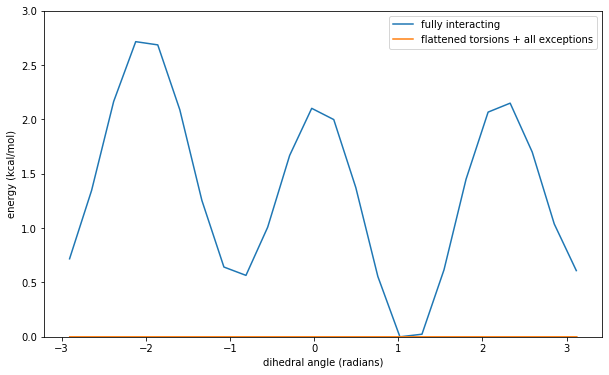

In [55]:
labels = ['fully interacting', 'flattened torsions + all exceptions']

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(torsion_scans)):
    ax.plot(list(torsion_scans_sorted[i].keys()), [mean for mean, stderr in list(torsion_scans_sorted[i].values())], label=labels[i])

ax.set(xlabel='dihedral angle (radians)', ylabel='energy (kcal/mol)')
ax.legend(loc='upper right')
ax.set_ylim([0, 3])
plt.show()